In [2]:
__author__ = 'John Evans'
__copyright__ = 'Copyright 2020 John Evans'
__credits__ = ['John Evans',]
__license__ = 'Apache License 2.0'
__version__ = '0.0.1'
__maintainer__ = 'John Evans'
__email__ = 'jevans96@umd.edu'
__status__ = 'Development'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
covid_data = pd.read_csv('./all-states-history.csv')

# Source: https://covidtracking.com/data/download/all-states-history.csv
# Date: 11/12/2020

voting_and_population = pd.read_csv('./voting_and_population_by_state.csv')

# Voting
# Source: https://www.nytimes.com/interactive/2020/11/03/us/elections/results-president.html
# Date: 11/12/2020
# Note: Manually entered

# Population
# Source: https://www.infoplease.com/us/states/state-population-by-rank
# Date: 11/12/2020

# Remove covid data not belonging to 50 states + DC
bad_states = set(covid_data['state'].unique()) - set(voting_and_population['Postal Code'].unique())
print(bad_states)

for state in bad_states:
    covid_data = covid_data[covid_data['state'] != state]
    
# Sort covid data by date
covid_data = covid_data.sort_values(by=['date'])

# Set negative values in positiveIncrease to 0
covid_data['positiveIncrease'] = covid_data['positiveIncrease'].clip(lower = 0)

# Convert dates to correct format
covid_data['date'] = pd.to_datetime(covid_data['date'])
covid_data = covid_data.set_index('date')

# Convert voting percentages to correct format
voting_and_population['Biden'] = voting_and_population['Biden'].str.rstrip('%').astype('float') / 100.0
voting_and_population['Trump'] = voting_and_population['Trump'].str.rstrip('%').astype('float') / 100.0

{'GU', 'AS', 'PR', 'MP', 'VI'}


In [7]:
# Plot running 7 day case average per state

fig, axes = plt.subplots(8, 7, figsize=(50,50), sharex=True, sharey=True)

for state, ax in zip(covid_data['state'].unique(), axes.flatten()):
    state_data = covid_data[covid_data['state'] == state]
    daily_positives = state_data['positiveIncrease']
    ax.bar(daily_positives.index, daily_positives, color='C0', label='Positive Cases')
    ax.plot(daily_positives.index, daily_positives.rolling('7D').mean(), color='C1', label='7 day rolling average')
    ax.set_title(f'{state}')
    ax.legend()
    ax.xaxis.set_tick_params(labelbottom=True)

for i in range(5):
    fig.delaxes(axes[7][2+i])

plt.tight_layout()
plt.savefig('./states.pdf')
plt.close()

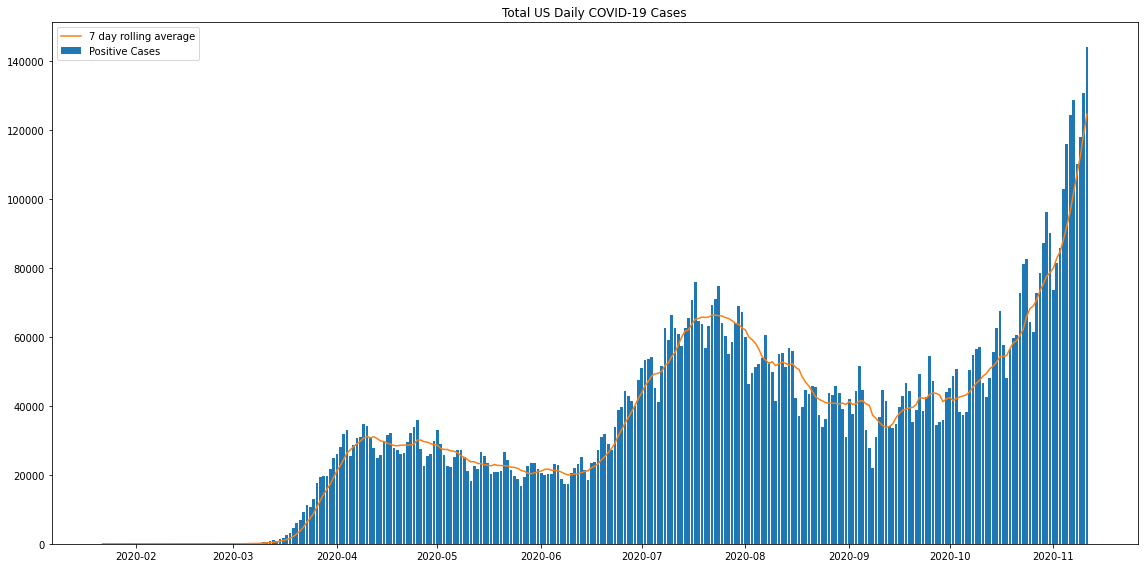

In [7]:
# Plot running 7 day case average for whole US

fig, ax = plt.subplots(figsize=(16,8))

us_data = covid_data.groupby(['date'])
daily_positives = us_data['positiveIncrease'].sum()
mean_daily_positives = daily_positives.rolling('7D').mean()
ax.bar(daily_positives.index, daily_positives, color='C0', label='Positive Cases')
ax.plot(daily_positives.index, mean_daily_positives, color='C1', label='7 day rolling average')
ax.legend()
ax.set_title('Total US Daily COVID-19 Cases')

plt.tight_layout()
plt.savefig('./us.pdf')
plt.show()
plt.close()

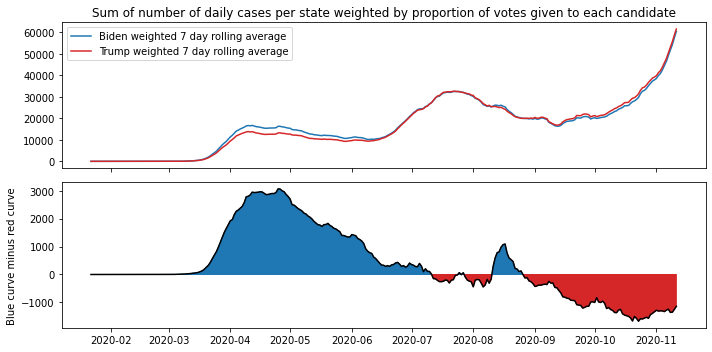

In [18]:
# Plot 7 day rolling case average weighted by candidate

biden_data = covid_data.copy()
trump_data = covid_data.copy()
biden_data['positiveIncrease'] = biden_data['positiveIncrease'].astype('float')
trump_data['positiveIncrease'] = trump_data['positiveIncrease'].astype('float')

for state in covid_data['state'].unique():
    biden = voting_and_population[voting_and_population['Postal Code'] == state]['Biden'].values[0]
    trump = voting_and_population[voting_and_population['Postal Code'] == state]['Trump'].values[0]
    biden_data.loc[biden_data['state'] == state, 'positiveIncrease'] *= biden
    trump_data.loc[trump_data['state'] == state, 'positiveIncrease'] *= trump

fig, axes = plt.subplots(2, 1, figsize=(10,5), sharex=True)

biden_data = biden_data.groupby(['date'])
trump_data = trump_data.groupby(['date'])
biden_daily_positives = biden_data['positiveIncrease'].sum()
trump_daily_positives = trump_data['positiveIncrease'].sum()

biden_rolling_mean = biden_daily_positives.rolling('7D').mean()
trump_rolling_mean = trump_daily_positives.rolling('7D').mean()

axes[0].plot(biden_daily_positives.index, biden_rolling_mean, color='C0', label='Biden weighted 7 day rolling average')
axes[0].plot(trump_daily_positives.index, trump_rolling_mean, color='C3', label='Trump weighted 7 day rolling average')
axes[0].set_title('Sum of number of daily cases per state weighted by proportion of votes given to each candidate')
axes[0].legend()

diff = biden_rolling_mean - trump_rolling_mean
axes[1].plot(biden_daily_positives.index, diff, color='k')
axes[1].fill_between(biden_daily_positives.index, diff, where=(diff>0), color='C0', interpolate=True)
axes[1].fill_between(biden_daily_positives.index, diff, where=(diff<0), color='C3', interpolate=True)
axes[1].set_ylabel('Blue curve minus red curve')

plt.tight_layout()
plt.savefig('./us_weighted.pdf')
plt.savefig('./us_weighted.png')
plt.show()
plt.close()

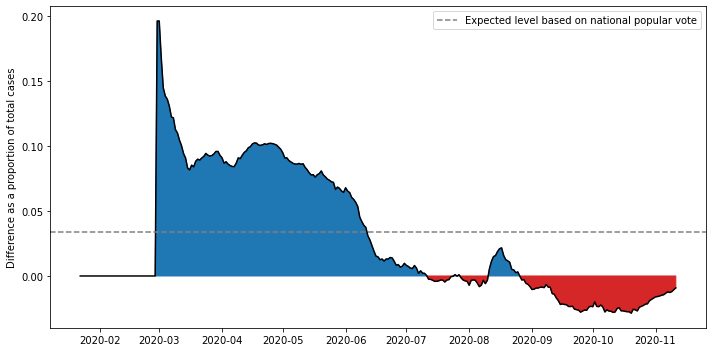

In [23]:
fig, ax = plt.subplots(figsize=(10,5), sharex=True)

diff = (biden_rolling_mean - trump_rolling_mean) / mean_daily_positives 
diff = diff.fillna(0)
expectation = .508 - .474
ax.plot(biden_daily_positives.index, diff, color='k')
ax.fill_between(biden_daily_positives.index, diff, where=(diff>0), color='C0', interpolate=True)
ax.fill_between(biden_daily_positives.index, diff, where=(diff<0), color='C3', interpolate=True)
ax.axhline(expectation, color='grey', linestyle='--', label='Expected level based on national popular vote')
ax.set_ylabel('Difference as a proportion of total cases')
ax.legend()

plt.tight_layout()
plt.savefig('./us_weighted.pdf')
plt.savefig('./us_weighted.png')
plt.show()
plt.close()